In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
import matplotlib.pyplot as plt 
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Mollet','PratDelLlobregat']
fsize=20

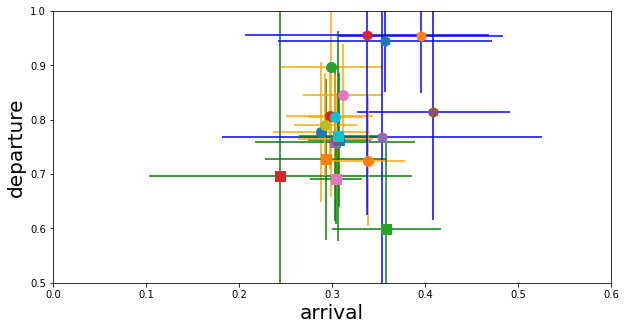

In [5]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,5), sharey=True)
for current_parking_ix in range(8):
    current_parking = available_parkings[current_parking_ix]
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
         errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
    f.close()
    mu_aWD=optimal_params_weekdaytn.x[0]
    si_aWD=optimal_params_weekdaytn.x[1]
    mu_dWD=optimal_params_weekdaytn.x[2]
    si_dWD=optimal_params_weekdaytn.x[3]

    mu_aFR=optimal_params_fridaytn.x[0]
    si_aFR=optimal_params_fridaytn.x[1]
    mu_dFR=optimal_params_fridaytn.x[2]
    si_dFR=optimal_params_fridaytn.x[3]

    mu_aWE=optimal_params_weekendtn.x[0]
    si_aWE=optimal_params_weekendtn.x[1]
    mu_dWE=optimal_params_weekendtn.x[2]
    si_dWE=optimal_params_weekendtn.x[3]
    
    ax2.plot(mu_aWD,mu_dWD,'o',markersize=10)
    ax2.errorbar(mu_aWD,mu_dWD,xerr=si_aWD,yerr=si_dWD,color='orange')
    #ax2.plot([mu_aWD+si_aWD, mu_aWD-si_aWD],[mu_dWD, mu_dWD],'-')
    
    ax2.plot(mu_aFR,mu_dFR,'s',markersize=10)
    ax2.errorbar(mu_aFR,mu_dFR,xerr=si_aFR,yerr=si_dFR,color='green')
    #ax2.plot([mu_aWD, mu_aWD],[mu_dWD+si_dWD, mu_dWD-si_dWD],'-')
    #ax2.plot(mu_aFR,mu_dFR,'s')
    #ax2.plot(mu_aWE,mu_dWE,'p')
    ax2.plot(mu_aWE,mu_dWE,'h',markersize=10)
    ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='blue')
    
    
    ax2.set_xlim([0,0.6])
    ax2.set_ylim([0.5,1])
    ax2.set_ylabel('departure', fontsize = fsize)
    ax2.set_xlabel('arrival', fontsize = fsize)

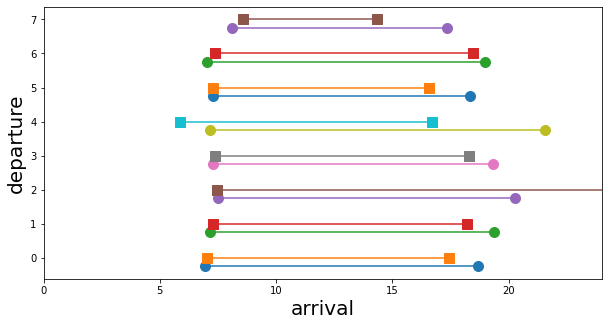

In [6]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,5), sharey=True)


num_stations=len(available_parkings)
mu_aWD = np.zeros(num_stations)
si_aWD = np.zeros(num_stations)
mu_dWD = np.zeros(num_stations)
si_dWD = np.zeros(num_stations)

mu_aFR = np.zeros(num_stations)
si_aFR = np.zeros(num_stations)
mu_dFR = np.zeros(num_stations)
si_dFR = np.zeros(num_stations)

mu_aWE = np.zeros(num_stations)
si_aWE = np.zeros(num_stations)
mu_dWE = np.zeros(num_stations)
si_dWE = np.zeros(num_stations)

i=0
for current_parking_ix in range(num_stations):

    current_parking = available_parkings[current_parking_ix]
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
         errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
    f.close()
    mu_aWD[i]=optimal_params_weekdaytn.x[0]
    si_aWD[i]=optimal_params_weekdaytn.x[1]
    mu_dWD[i]=optimal_params_weekdaytn.x[2]
    si_dWD[i]=optimal_params_weekdaytn.x[3]

    mu_aFR[i]=optimal_params_fridaytn.x[0]
    si_aFR[i]=optimal_params_fridaytn.x[1]
    mu_dFR[i]=optimal_params_fridaytn.x[2]
    si_dFR[i]=optimal_params_fridaytn.x[3]

    mu_aWE[i]=optimal_params_weekendtn.x[0]
    si_aWE[i]=optimal_params_weekendtn.x[1]
    mu_dWE[i]=optimal_params_weekendtn.x[2]
    si_dWE[i]=optimal_params_weekendtn.x[3]
    
    ax2.plot([mu_aWD[i]*24, mu_dWD[i]*24],[i-0.25, i-0.25],'-o',markersize=10)
    #ax2.errorbar(mu_aWD,mu_dWD,xerr=si_aWD,yerr=si_dWD,color='orange')
    #ax2.plot([mu_aWD+si_aWD, mu_aWD-si_aWD],[mu_dWD, mu_dWD],'-')
    
    ax2.plot([mu_aFR[i]*24, mu_dFR[i]*24],[i, i],'-s',markersize=10)
    #ax2.errorbar(mu_aFR,mu_dFR,xerr=si_aFR,yerr=si_dFR,color='green')
    #ax2.plot([mu_aWD, mu_aWD],[mu_dWD+si_dWD, mu_dWD-si_dWD],'-')
    #ax2.plot(mu_aFR,mu_dFR,'s')
    #ax2.plot(mu_aWE,mu_dWE,'p')
    #ax2.plot([mu_aWE*24,mu_dWE*24],[i+0.25, i+0.25],'-h',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='blue')
    
    
    ax2.set_xlim([0,24])
    #ax2.set_ylim([0.5,1])
    ax2.set_ylabel('departure', fontsize = fsize)
    ax2.set_xlabel('arrival', fontsize = fsize)
    
    i=i+1

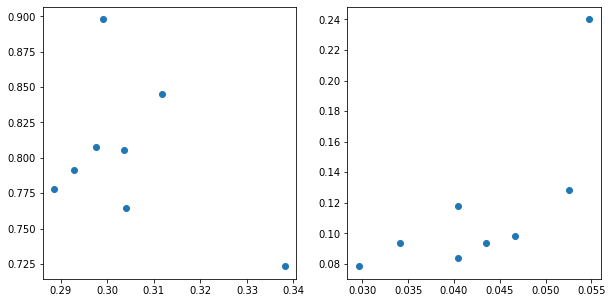

In [7]:
fig, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=False)
ax2[0].plot(mu_aWD,mu_dWD,'o')
ax2[1].plot(si_aWD,si_dWD,'o')

In [8]:
import scipy 
r, p = scipy.stats.pearsonr(mu_aWD,mu_dWD)
print(r)
print(p)

-0.41954779417474775
0.3007844794052553


In [9]:
r, p = scipy.stats.pearsonr(mu_aWD[:-1],mu_dWD[:-1])
print(r)
print(p)

0.31024059359641387
0.4982952696812208


In [10]:
mu_aWD

array([0.28858668, 0.29758856, 0.31170596, 0.30350063, 0.29906572,
       0.30400155, 0.29291107, 0.3381864 ])

In [11]:
r, p = scipy.stats.pearsonr(si_aWD,si_dWD)
print(r)
print(p)

0.7258488658924539
0.04150134843341372


In [16]:
def plot_model_tn_offset(axh,loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1,offset=0,mylabelC=None):
    
    default_color_cycle=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

    # arrivals
    a_ar = -loc_ar/scale_ar
    b_ar = (1-loc_ar)/scale_ar

    # departures
    a_de = -loc_de/scale_de
    b_de = (1-loc_de)/scale_de

    time = np.linspace(0,23.5,48)
    time_tn=time/24

    pdf_ar = truncnorm.pdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    pdf_de = truncnorm.pdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)
    cdf_ar = truncnorm.cdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    cdf_de = truncnorm.cdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)

    #fig, ax = plt.subplots(2)
    #ax[0].plot(time, pdf_ar, '-b')
    #ax[0].plot(time, pdf_de, '-r')
    #ax[0].set_title('pdfs')

    #ax[1].plot(time, cdf_ar , '--b')
    #ax[1].plot(time, cdf_de, '--r')
    axh.plot(time, cdf_ar-cdf_de+offset, color=default_color_cycle[i],label=mylabelC)
    #ax[1].set_title('cdfs')

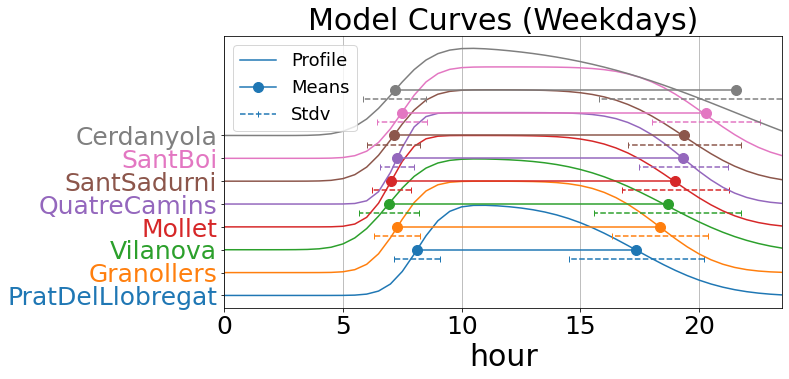

In [26]:
fsize=30
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
i=0;


default_color_cycle=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
#reindex = np.flip((mu_dWD-mu_aWD).argsort())
reindex = (mu_dWD-mu_aWD).argsort()
mu_aWDr = mu_aWD[reindex]
si_aWDr = si_aWD[reindex]
mu_dWDr = mu_dWD[reindex]
si_dWDr = si_dWD[reindex]

available_parkings_reindexed = [available_parkings[i] for i in reindex]

for current_parking_ix in range(8):
    if i==0:
        mylabelM="Means"
        mylabelS="Stdv"
        mylabelC="Profile"
    else:
        mylabelM=None 
        mylabelS=None 
        mylabelC=None
    
    #ax2.plot([mu_aWD*24, mu_dWD*24],[i-0.25, i-0.25],'-o',markersize=10)
    #ax2.errorbar(mu_aWD,mu_dWD,xerr=si_aWD,yerr=si_dWD,color='orange')
    #ax2.plot([mu_aWD+si_aWD, mu_aWD-si_aWD],[mu_dWD, mu_dWD],'-')
    
    #ax2.plot([mu_aFR*24, mu_dFR*24],[i, i],'-s',markersize=10)
    #ax2.errorbar(mu_aFR,mu_dFR,xerr=si_aFR,yerr=si_dFR,color='green')
    #ax2.plot([mu_aWD, mu_aWD],[mu_dWD+si_dWD, mu_dWD-si_dWD],'-')
    #ax2.plot(mu_aFR,mu_dFR,'s')
    #ax2.plot(mu_aWE,mu_dWE,'p')
    #ax2.plot([mu_aWE*24,mu_dWE*24],[i+0.25, i+0.25],'-h',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='blue')
    plot_model_tn_offset(ax2,mu_aWDr[i],si_aWDr[i],mu_dWDr[i],si_dWDr[i],i/4,mylabelC)
    ax2.plot([mu_aWDr[i]*24, mu_dWDr[i]*24],[i/4+.5, i/4+.5],'-o',markersize=10,label=mylabelM)
    ax2.plot([(mu_aWDr[i]+si_aWDr[i])*24, (mu_aWDr[i]-si_aWDr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i],label=mylabelS)
    ax2.plot([(mu_dWDr[i]+si_dWDr[i])*24, (mu_dWDr[i]-si_dWDr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i]) 
    i=i+1
ax2.set_xlim([0,24])
ax2.set_yticks(np.arange(0, 2, .25))
ax2.set_yticklabels(available_parkings_reindexed, fontsize=fsize)
ax2.tick_params(labelsize=fsize-5)
[t.set_color(i) for (i,t) in zip(default_color_cycle,ax2.yaxis.get_ticklabels())]
#ax2.set_ylim([0.5,1])
ax2.set_xlim([0,23.5])
#ax2.set_ylabel('departure', fontsize = fsize)
ax2.set_xlabel('hour', fontsize = fsize)
#ax2.grid(True)
ax2.xaxis.grid(True)
ax2.legend( fontsize = fsize-12)
ax2.set_title('Model Curves (Weekdays)', fontsize = fsize);
    #ax2.grid(which='major',linestyle='dotted')
fig.savefig('Model_curves_w_ErrorbarsWD.pdf',bbox_inches='tight');

In [27]:
mu_dWDr*24

array([17.35772645, 18.34620451, 18.67231535, 18.98719184, 19.33872708,
       19.38344901, 20.29043924, 21.54930476])

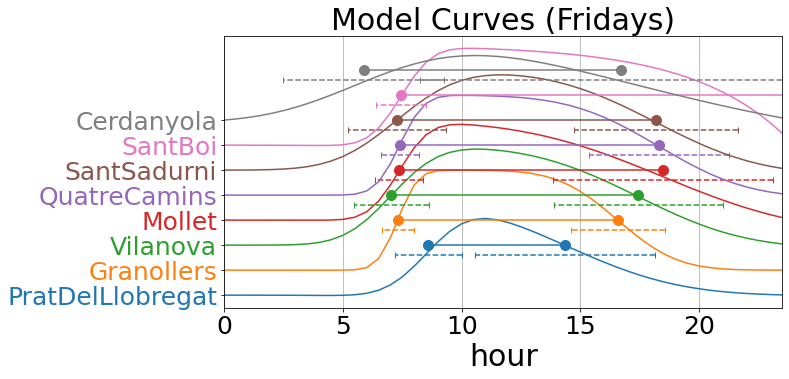

In [29]:
fsize=30
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
i=0;


default_color_cycle=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
#reindex = np.flip((mu_dFR-mu_aFR).argsort())
#reindex = (mu_dFR-mu_aFR).argsort()
mu_aFRr = mu_aFR[reindex]
si_aFRr = si_aFR[reindex]
mu_dFRr = mu_dFR[reindex]
si_dFRr = si_dFR[reindex]

available_parkings_reindexed = [available_parkings[i] for i in reindex]

for current_parking_ix in range(8):
    if i==0:
        mylabelM="Means"
        mylabelS="Stdv"
        mylabelC="Profile"
    else:
        mylabelM=None 
        mylabelS=None 
        mylabelC=None
    
    #ax2.plot([mu_aFR*24, mu_dFR*24],[i-0.25, i-0.25],'-o',markersize=10)
    #ax2.errorbar(mu_aFR,mu_dFR,xerr=si_aFR,yerr=si_dFR,color='orange')
    #ax2.plot([mu_aFR+si_aFR, mu_aFR-si_aFR],[mu_dFR, mu_dFR],'-')
    
    #ax2.plot([mu_aFR*24, mu_dFR*24],[i, i],'-s',markersize=10)
    #ax2.errorbar(mu_aFR,mu_dFR,xerr=si_aFR,yerr=si_dFR,color='green')
    #ax2.plot([mu_aFR, mu_aFR],[mu_dFR+si_dFR, mu_dFR-si_dFR],'-')
    #ax2.plot(mu_aFR,mu_dFR,'s')
    #ax2.plot(mu_aWE,mu_dWE,'p')
    #ax2.plot([mu_aWE*24,mu_dWE*24],[i+0.25, i+0.25],'-h',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='blue')
    plot_model_tn_offset(ax2,mu_aFRr[i],si_aFRr[i],mu_dFRr[i],si_dFRr[i],i/4,mylabelC)
    ax2.plot([mu_aFRr[i]*24, mu_dFRr[i]*24],[i/4+.5, i/4+.5],'-o',markersize=10,label=mylabelM)
    ax2.plot([(mu_aFRr[i]+si_aFRr[i])*24, (mu_aFRr[i]-si_aFRr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i],label=mylabelS)
    ax2.plot([(mu_dFRr[i]+si_dFRr[i])*24, (mu_dFRr[i]-si_dFRr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i]) 
    i=i+1
ax2.set_xlim([0,24])
ax2.set_yticks(np.arange(0, 2, .25))
ax2.set_yticklabels(available_parkings_reindexed, fontsize=fsize)
ax2.tick_params(labelsize=fsize-5)
[t.set_color(i) for (i,t) in zip(default_color_cycle,ax2.yaxis.get_ticklabels())]
#ax2.set_ylim([0.5,1])
ax2.set_xlim([0,23.5])
#ax2.set_ylabel('departure', fontsize = fsize)
ax2.set_xlabel('hour', fontsize = fsize)
#ax2.grid(True)
ax2.xaxis.grid(True)
#ax2.legend( fontsize = fsize-5)
ax2.set_title('Model Curves (Fridays)', fontsize = fsize);
    #ax2.grid(which='major',linestyle='dotted')
fig.savefig('Model_curves_w_ErrorbarsFR.pdf',bbox_inches='tight');


In [14]:
mu_dFRr*24

array([  14.36096341,   16.5712169 ,   17.44708356,   18.48076054,
         18.31377199,   18.19991419, 6809.89006505,   16.69488877])

NameError: name 'plot_model_tn_offset' is not defined

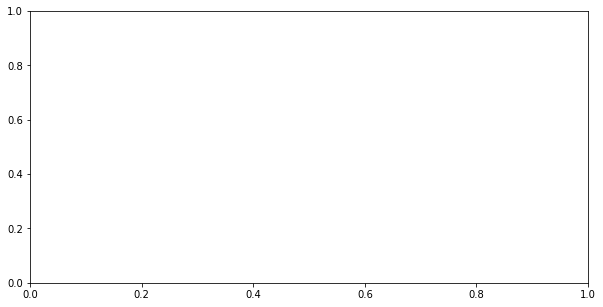

In [15]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
i=0;


default_color_cycle=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
#reindex = np.flip((mu_dWE-mu_aWE).argsort())
#reindex = (mu_dWE-mu_aWE).argsort()
mu_aWEr = mu_aWE[reindex]
si_aWEr = si_aWE[reindex]
mu_dWEr = mu_dWE[reindex]
si_dWEr = si_dWE[reindex]

available_parkings_reindexed = [available_parkings[i] for i in reindex]

for current_parking_ix in range(8):
    if i==0:
        mylabelM="Means"
        mylabelS="Stdv"
        mylabelC="Profile"
    else:
        mylabelM=None 
        mylabelS=None 
        mylabelC=None
    
    #ax2.plot([mu_aWE*24, mu_dWE*24],[i-0.25, i-0.25],'-o',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='orange')
    #ax2.plot([mu_aWE+si_aWE, mu_aWE-si_aWE],[mu_dWE, mu_dWE],'-')
    
    #ax2.plot([mu_aWE*24, mu_dWE*24],[i, i],'-s',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='green')
    #ax2.plot([mu_aWE, mu_aWE],[mu_dWE+si_dWE, mu_dWE-si_dWE],'-')
    #ax2.plot(mu_aWE,mu_dWE,'s')
    #ax2.plot(mu_aWE,mu_dWE,'p')
    #ax2.plot([mu_aWE*24,mu_dWE*24],[i+0.25, i+0.25],'-h',markersize=10)
    #ax2.errorbar(mu_aWE,mu_dWE,xerr=si_aWE,yerr=si_dWE,color='blue')
    plot_model_tn_offset(ax2,mu_aWEr[i],si_aWEr[i],mu_dWEr[i],si_dWEr[i],i/4,mylabelC)
    ax2.plot([mu_aWEr[i]*24, mu_dWEr[i]*24],[i/4+.5, i/4+.5],'-o',markersize=10,label=mylabelM)
    ax2.plot([(mu_aWEr[i]+si_aWEr[i])*24, (mu_aWEr[i]-si_aWEr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i],label=mylabelS)
    ax2.plot([(mu_dWEr[i]+si_dWEr[i])*24, (mu_dWEr[i]-si_dWEr[i])*24],[i/4+.5-0.1, i/4+.5-0.1],
             '--|',color=default_color_cycle[i]) 
    i=i+1
ax2.set_xlim([0,24])
ax2.set_yticks(np.arange(0, 2, .25))
ax2.set_yticklabels(available_parkings_reindexed, fontsize=fsize)
ax2.tick_params(labelsize=fsize)
[t.set_color(i) for (i,t) in zip(default_color_cycle,ax2.yaxis.get_ticklabels())]
#ax2.set_ylim([0.5,1])
ax2.set_xlim([0,23.5])
#ax2.set_ylabel('departure', fontsize = fsize)
ax2.set_xlabel('hour', fontsize = fsize)
#ax2.grid(True)
ax2.xaxis.grid(True)
#ax2.legend( fontsize = fsize-5)
ax2.set_title('Model Curves (Weekends)', fontsize = fsize);
    #ax2.grid(which='major',linestyle='dotted')
plt.show()
fig.savefig('Model_curves_w_ErrorbarsWE.pdf',bbox_inches='tight');

In [7]:
optimal_params_weekdaytn

 final_simplex: (array([[0.29291107, 0.03415998, 0.79113299, 0.09391115],
       [0.29291127, 0.03416001, 0.79113323, 0.09391174],
       [0.29291125, 0.0341598 , 0.79113333, 0.09391085],
       [0.29291113, 0.03416041, 0.79113333, 0.09391119],
       [0.29291142, 0.03416018, 0.79113281, 0.09391166]]), array([0.01570879, 0.01570879, 0.01570879, 0.01570879, 0.01570879]))
           fun: 0.015708785409765964
       message: 'Optimization terminated successfully.'
          nfev: 256
           nit: 152
        status: 0
       success: True
             x: array([0.29291107, 0.03415998, 0.79113299, 0.09391115])

In [6]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24



In [7]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd.copy()

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
prototype_math_dep_weekday=cdf2_wd


resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd
prototype_math_weekday_plot = resta_wd_plot

### FRIDAYS

In [8]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [9]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri


resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri
prototype_math_friday_plot = resta_fri_plot


### WEEKENDS

In [10]:
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])

cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we

In [11]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Denormalization / Rescaling

In [12]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [13]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [14]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

## Running  Prediction

In [15]:
starting_hour=7
ending_hour=15

In [16]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

tn_arr_proto_dict={}
tn_arr_proto_dict["Monday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Tuesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Wednesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Thursday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Friday"] = tn_arr_friday_nooff


tn_dep_proto_dict={}
tn_dep_proto_dict["Monday"] = tn_dep_weekday
tn_dep_proto_dict["Tuesday"] = tn_dep_weekday
tn_dep_proto_dict["Wednesday"] = tn_dep_weekday
tn_dep_proto_dict["Thursday"] = tn_dep_weekday
tn_dep_proto_dict["Friday"] = tn_dep_friday


t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wdTH=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_frTH=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_weTH=[None] * len(predWindow_vec)


for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        if day not in ['Saturday','Sunday']:
            
            tn_arr_proto = tn_arr_proto_dict[day]
            tn_dep_proto = tn_dep_proto_dict[day]
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNowTHv2(t_days,hist_proto,
                                                                            tn_arr_proto,tn_dep_proto,max_value,
                                                                            starting_hour,pred_window,ending_hour)
        else:
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                              tn_proto,max_value,starting_hour,
                                                                              pred_window,ending_hour)
        
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wdTH[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wdTH[j]=np.concatenate((tn_running_errorNOW_wdTH[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_frTH[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_weTH[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_weTH[j]=np.concatenate((tn_running_errorNOW_weTH[j], tn_running_error_vec_now), axis=1)
        
        
        
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [17]:
tn_running_error_wdTH=tn_running_errorNOW_wdTH[0]
tn_running_error_frTH=tn_running_errorNOW_frTH[0]
tn_running_error_weTH=tn_running_errorNOW_weTH[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

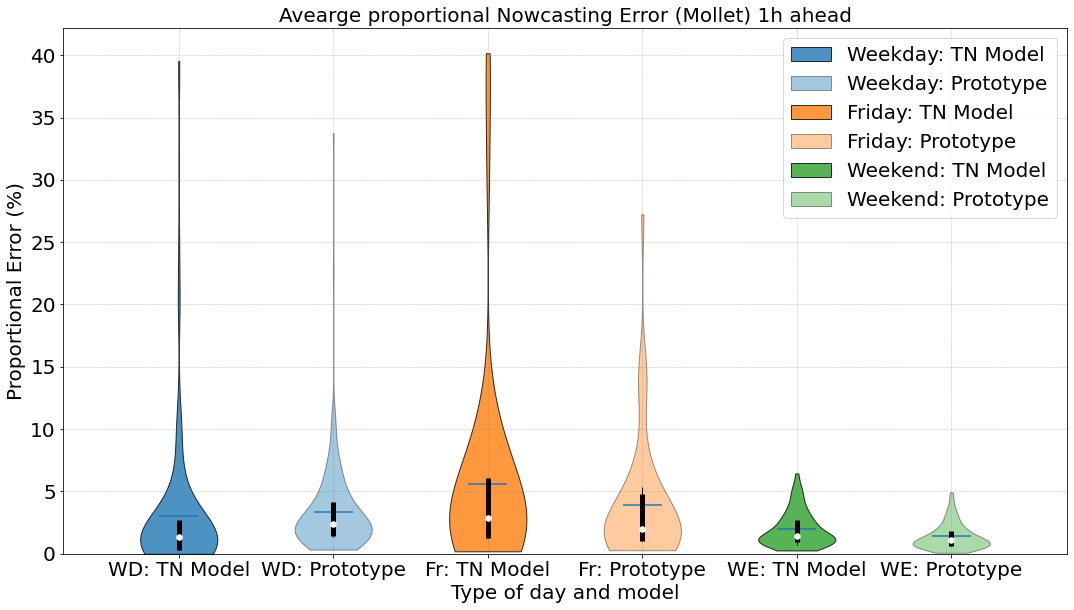

In [18]:
data = [tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_frTH.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_weTH.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
fsize=20
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_weTH.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
#fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h_TH_till'+ending_hour +'h.pdf',bbox_inches='tight');

## Model without treshold

In [19]:
with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
         errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
    f.close()

In [20]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])


resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

In [21]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])


cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)

In [22]:
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])


cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])


resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)

In [23]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [24]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [25]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)



for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                            tn_proto,max_value,starting_hour,pred_window,ending_hour)
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
            
            
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [26]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

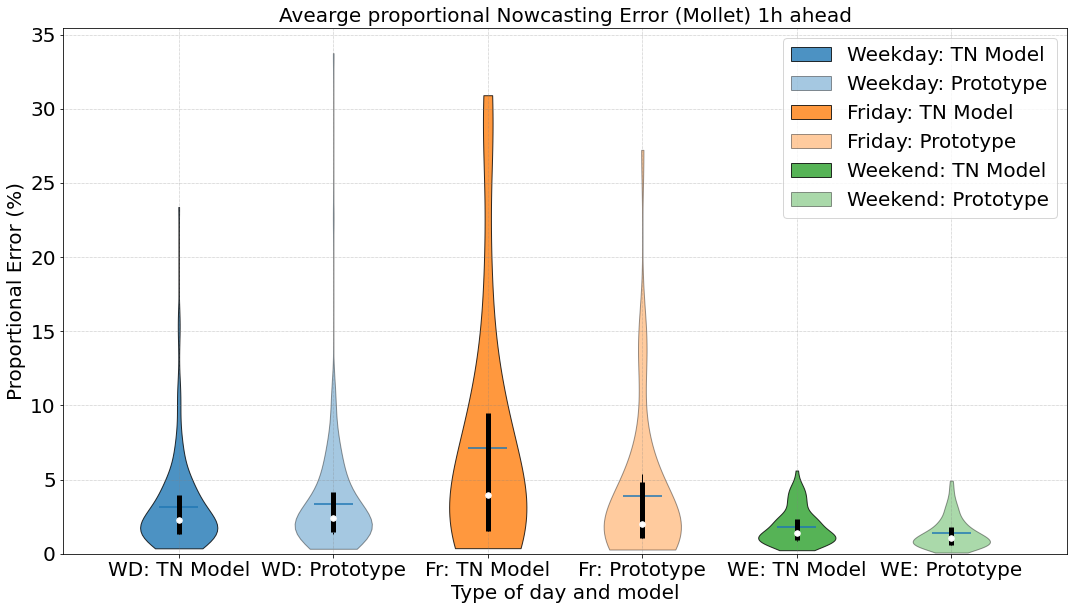

In [27]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
#fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h_till'+ending_hour +'h.pdf,bbox_inches='tight');

[2.29 1.32 2.38 3.96 2.88 2.03]


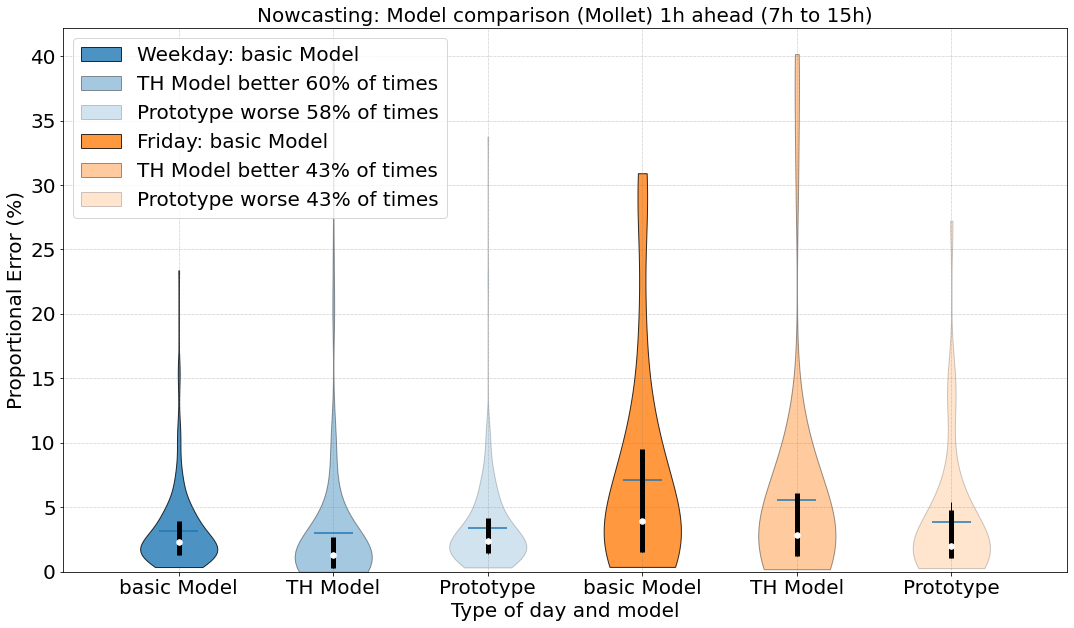

In [28]:
data = [tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()]
#,tn_running_error_we.flatten(),tn_running_error_weTH.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Nowcasting: Model comparison ("+ current_parking+') 1h ahead ('+str(starting_hour)
              + 'h to '+ str(ending_hour) +'h)', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%3==1:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.8)
    elif cc%3==2:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.4)   
    else:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.2)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),tn_running_error_frTH.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
#quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),tn_running_error_weTH.flatten()], [25, 50, 75], axis=1)

#quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
#medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
#quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)

quartile1=np.concatenate((quartile1wd, quartile1fr), axis=0)
medians=np.concatenate((medianswd, mediansfr), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr), axis=0)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


np.set_printoptions(precision=2)
print(medians)



propTHbetter_wd=sum(tn_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propTHbetter_fr=sum(tn_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())
propworseTH_wd=sum(proto_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propworseTH_fr=sum(proto_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())


# set style for the axes
labels = ['basic Model', 'TH Model','Prototype','basic Model', 'TH Model','Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

#ax2.legend(['Weekday: basic Model','Weekday: TH Model','Friday: basic Model','Friday: TH Model',
#           'Weekend: basic Model','Weekend: basic Model'], fontsize=fsize)

ax2.legend(['Weekday: basic Model','TH Model better ' +str(int(propTHbetter_wd*100)) +'% of times',
            'Prototype worse ' +str(int(propworseTH_wd*100)) +'% of times',
            'Friday: basic Model','TH Model better '+str(int(propTHbetter_fr*100)) +'% of times',
            'Prototype worse ' +str(int(propworseTH_fr*100)) +'% of times'], fontsize=fsize, loc='upper left')
#ax2.tick_params(axis='y', labelsize=20)
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('CompareRunningPredictionError_'+current_parking+'_violin_NOW1h_till'+str(ending_hour) +'hv2.pdf',bbox_inches='tight');

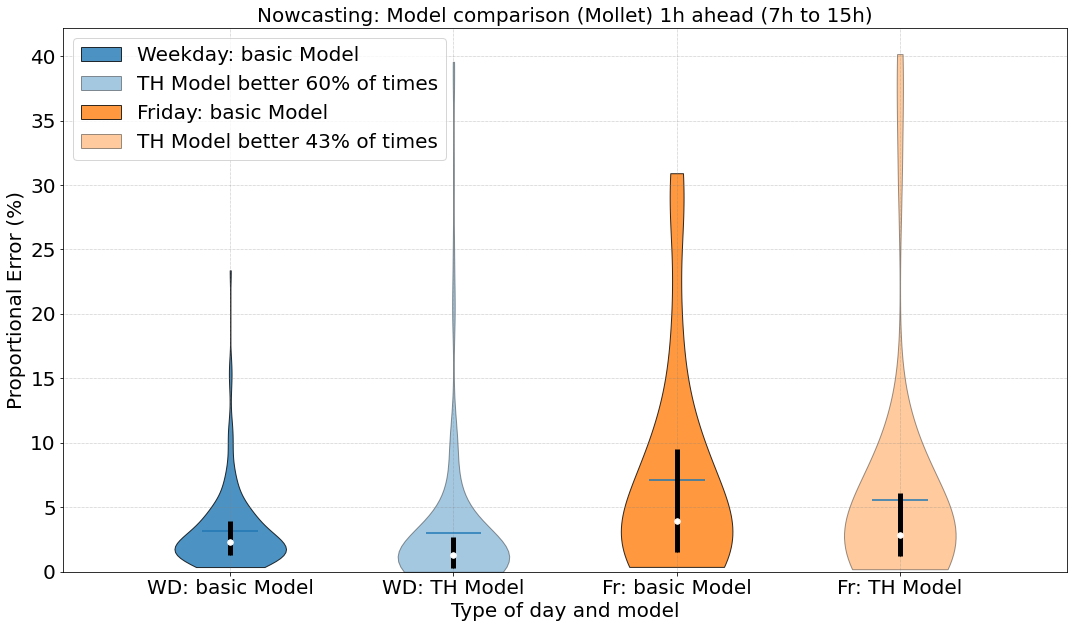

In [29]:
data = [tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten(),
        tn_running_error_fr.flatten(),tn_running_error_frTH.flatten()]
#,tn_running_error_we.flatten(),tn_running_error_weTH.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Nowcasting: Model comparison ("+ current_parking+') 1h ahead ('+str(starting_hour)
              + 'h to '+ str(ending_hour) +'h)', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),tn_running_error_wdTH.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),tn_running_error_frTH.flatten()], [25, 50, 75], axis=1)
#quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),tn_running_error_weTH.flatten()], [25, 50, 75], axis=1)

#quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
#medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
#quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)

quartile1=np.concatenate((quartile1wd, quartile1fr), axis=0)
medians=np.concatenate((medianswd, mediansfr), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr), axis=0)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


propTHbetter_wd=sum(tn_running_error_wd.flatten()>tn_running_error_wdTH.flatten())/len(tn_running_error_wd.flatten())
propTHbetter_fr=sum(tn_running_error_fr.flatten()>tn_running_error_frTH.flatten())/len(tn_running_error_fr.flatten())

# set style for the axes
labels = ['WD: basic Model', 'WD: TH Model','Fr: basic Model', 'Fr: TH Model'] #,'WE: TN Model', 'WE: TN Model']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

#ax2.legend(['Weekday: basic Model','Weekday: TH Model','Friday: basic Model','Friday: TH Model',
#           'Weekend: basic Model','Weekend: basic Model'], fontsize=fsize)

ax2.legend(['Weekday: basic Model','TH Model better ' +str(int(propTHbetter_wd*100)) +'% of times',
            'Friday: basic Model','TH Model better '+str(int(propTHbetter_fr*100)) +'% of times',], fontsize=fsize, loc='upper left')
#ax2.tick_params(axis='y', labelsize=20)
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('CompareRunningPredictionError_'+current_parking+'_violin_NOW1h_till'+str(ending_hour) +'h.pdf',bbox_inches='tight');